# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Importing Libraries

In [1]:
import os
from os import path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from PIL import Image
from mlxtend.data import loadlocal_mnist

## Unzipping the zip file

In [ ]:
!unzip '/content/gdrive/MyDrive/4.2/CSE 4238/Dataset C.zip'

# Reading Data From the csv File

In [2]:
for dirname, _, filenames in os.walk('../input/cse-4238/Dataset_2/Dataset_2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/cse-4238/Dataset_2/Dataset_2/t10k-labels-idx1-ubyte
../input/cse-4238/Dataset_2/Dataset_2/verification_train.csv
../input/cse-4238/Dataset_2/Dataset_2/t10k-images-idx3-ubyte
../input/cse-4238/Dataset_2/Dataset_2/verification_test.csv
../input/cse-4238/Dataset_2/Dataset_2/train-labels-idx1-ubyte
../input/cse-4238/Dataset_2/Dataset_2/train-images-idx3-ubyte


In [3]:
training_images_filepath = '../input/cse-4238/Dataset_2/Dataset_2/train-images-idx3-ubyte'
training_labels_filepath = '../input/cse-4238/Dataset_2/Dataset_2/train-labels-idx1-ubyte'
test_images_filepath = '../input/cse-4238/Dataset_2/Dataset_2/t10k-images-idx3-ubyte'
test_labels_filepath = '../input/cse-4238/Dataset_2/Dataset_2/t10k-labels-idx1-ubyte'

In [4]:
X_train, y_train = loadlocal_mnist(training_images_filepath,training_labels_filepath)
X_test,y_test = loadlocal_mnist(test_images_filepath, test_labels_filepath)

In [5]:
print('Dimension of training images:', np.shape(X_train))
print('Dimension of trainig labels:',np.shape(y_train))
print('Dimension of testing images:', np.shape(X_test))
print('Dimension of testing labels:',np.shape(y_test))

Dimension of training images: (60000, 784)
Dimension of trainig labels: (60000,)
Dimension of testing images: (10000, 784)
Dimension of testing labels: (10000,)


In [6]:
X_train = X_train.reshape(60000, 28, 28)
X_test = X_test.reshape(10000, 28, 28)


print('Dimension of training images:', np.shape(X_train))
print('Dimension of testing images:', np.shape(X_test))

Dimension of training images: (60000, 28, 28)
Dimension of testing images: (10000, 28, 28)


# Converting Images and Transforming them to Train and Test

In [7]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data[index]
        pil_image = Image.fromarray(np.uint8(image)).convert('L')
        label = self.root[index]
        
        if self.transform is not None:
            image = self.transform(pil_image)
            
        return image, label

In [8]:
mean = [0.5,]
std = [0.5,]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data = Dataset(X_train, y_train, train_transform)
test_data = Dataset(X_test, y_test, test_transform)

print("Trainig Samples: ",len(train_data))
print("Trainig Samples: ",len(test_data))

Trainig Samples:  60000
Trainig Samples:  10000


# Hyperparameter Setting 6 Exp.2 Task 3
*   No of hidden layers = 3
*   Hidden Nodes = 784-300-200-100-10
*   Iteration = 80000
*   Learning rate = 0.05
*   Batch Size = 64
*   Activation Function : ReLU,ReLU6
*   Optimizer : SGD
*   Accuracy : 89.33%

In [9]:
batch_size = 64
num_iters = 80000
input_dim = 28*28
output_dim = 10
learning_rate = 0.05
num_hidden = 300  #number of hidden nodes
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    shuffle=False)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:938
Test dataloader:157


In [10]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

85


# Creating Neural Network Model

In [11]:

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, 200)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU6()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(200,100)
        ## Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(100, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ## Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [12]:

'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size=input_dim,
                                num_classes=output_dim,
                                num_hidden = num_hidden)

#To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=300, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=300, out_features=200, bias=True)
  (relu_2): ReLU6()
  (linear_3): Linear(in_features=200, out_features=100, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

# Optimizer (SGD)

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [14]:

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels.long())

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.5915557146072388. Accuracy: 79.15
Iteration: 1000. Loss: 0.38243183493614197. Accuracy: 82.38
Iteration: 1500. Loss: 0.3647206425666809. Accuracy: 83.95
Iteration: 2000. Loss: 0.3141661584377289. Accuracy: 83.92
Iteration: 2500. Loss: 0.27420318126678467. Accuracy: 83.71
Iteration: 3000. Loss: 0.3518809378147125. Accuracy: 85.07
Iteration: 3500. Loss: 0.40135374665260315. Accuracy: 85.46
Iteration: 4000. Loss: 0.3848786950111389. Accuracy: 84.99
Iteration: 4500. Loss: 0.290677547454834. Accuracy: 86.29
Iteration: 5000. Loss: 0.3254828155040741. Accuracy: 85.51
Iteration: 5500. Loss: 0.4232683479785919. Accuracy: 86.84
Iteration: 6000. Loss: 0.31932753324508667. Accuracy: 87.02
Iteration: 6500. Loss: 0.49847903847694397. Accuracy: 87.02
Iteration: 7000. Loss: 0.34652429819107056. Accuracy: 87.69
Iteration: 7500. Loss: 0.36463379859924316. Accuracy: 86.24
Iteration: 8000. Loss: 0.16858094930648804. Accuracy: 87.56
Iteration: 8500. Loss: 0.3804015815258026. Accurac

# Plotting Loss Graph According to Iterations

[0.5915557146072388, 0.38243183493614197, 0.3647206425666809, 0.3141661584377289, 0.27420318126678467, 0.3518809378147125, 0.40135374665260315, 0.3848786950111389, 0.290677547454834, 0.3254828155040741, 0.4232683479785919, 0.31932753324508667, 0.49847903847694397, 0.34652429819107056, 0.36463379859924316, 0.16858094930648804, 0.3804015815258026, 0.3860556185245514, 0.4251963496208191, 0.2615719437599182, 0.19040189683437347, 0.07741843909025192, 0.2612302899360657, 0.15635021030902863, 0.2187352031469345, 0.41785064339637756, 0.301891028881073, 0.1782630980014801, 0.11922147870063782, 0.2649436593055725, 0.3173306882381439, 0.07751896977424622, 0.17587827146053314, 0.13647174835205078, 0.11999046057462692, 0.4751726984977722, 0.07991371303796768, 0.061929311603307724, 0.2908547520637512, 0.10883460938930511, 0.23748725652694702, 0.1877475529909134, 0.10889428853988647, 0.10149309039115906, 0.13815103471279144, 0.25090116262435913, 0.1858188360929489, 0.15545491874217987, 0.127573579549

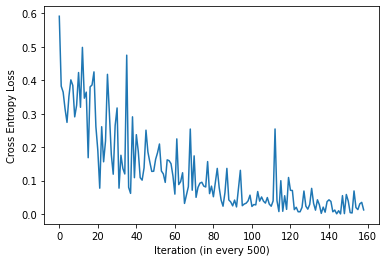

In [15]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.savefig('Task_3_Exp_2.png', dpi=600, bbox_inches='tight')
plt.show()

# Saving the Model

In [17]:
root_path = './Saved Models'
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'Task_3_Exp_2.pkl') 

In [18]:
print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 79730. Loss: 0.0650750920176506. Accuracy: 89.33
